# Analysing Isca output on Anthropocene

This is a guide to analysing the output of Isca simulations using Python and the [Jupyter](https://jupyter.org) Notebook interface on the Geography server Anthropocene.

Please **do not use the Blue Crystal login node for data analysis**. This has to deal with a large number of users, and is only meant for very basic operations like editing text files and submitting jobs. 

## Copying data from Anthropocene

We will follow an example of analysing some Isca-Mars with SOCRATES output. We will begin by copying some data over from Blue Crystal. First log in to Anthropocene:

```{bash}
localhost$ ssh -Y username@anthropocene.ggy.bris.ac.uk
```

(in this guide the name before the $ shows the system on which a given command is to be executed - 'localhost' is the computer in front of you). Here 'username' is your username (and for the rest of the guide). Note this can only be done from within Bristol, or on the Bristol VPN. If using Windows and PuTTY, there is a useful guide [here](https://github.com/rgnmudhar/MSci_Project/blob/master/Handover%20Document%20for%2060%20CP%20MSci%20Project%20A1005.docx). 

Next navigate to the scratch data storage directory on Anthropocene, and make a directory to hold your data.

```{bash}
anthropocene$ cd /export/anthropocene/array-01/username
anthropocene$ mkdir Isca_data
anthropocene$ cd Isca_data
```

Now copy the data from Blue Crystal (you may have to modify the last part of the path (`soc_mars_mk36_per_value70.85_none_mld_2.0_with_mola_topo`) to match the experiment name you want to copy):

```{bash}
anthropocene$ scp -r username@bc4login.acrc.bris.ac.uk:/mnt/storage/scratch/username/Isca_data/soc_mars_mk36_per_value70.85_none_mld_2.0_with_mola_topo .
```

# Setup Anaconda

To set up our python environment and use Jupyter Notebooks, we'll use Anaconda. First open up your `.bashrc` file:

```
anthropocene$ nano ~/.bashrc
```

Then add the following to the end of the file:

```
module load anaconda/3.7-2019.10
```

Now save with `Cntrl-O`, `Cntrl-X`. Then type `bash` and press enter to restart your shell. Now Anaconda will be loaded each time you log in. 

## Setup Python environment

Next we shoud setup a Python environment (which we'll call `isca`) for the analysis. This allows us to install some necessary packages which are not on Anthropocene by default. 

```{bash}
anthropocene$ cd $HOME
anthropocene$ mkdir Isca_analysis
anthropocene$ cd Isca_analysis
anthropocene$ conda create --name isca
anthropocene$ source activate isca
```

Now we will install some packages which will be useful with the model analysis: [Xarray](http://xarray.pydata.org/en/stable/index.html), [Cartopy](https://scitools.org.uk/cartopy/docs/latest/), and [Dask](https://dask.org).

```{bash}
(isca) anthropocene$ conda install ipython jupyter xarray dask 
(isca) anthropocene$ conda install -c conda-forge cartopy
```

Press 'y' whenever prompted (it may take a while to install). 

## Start Jupyter Notebook and forward to localhost

We will now start a Jupyter Notebook on Anthropocene, and connect to it with our local computer. 

First on on Anthropocene, start the Notebook:

```{bash}
(isca) anthropocene$ jupyter notebook --no-browser --port 10001
```

You should see a url, something like `http://localhost:10001/?token=21653106a744639ce449095dcf8405cbd667aa9f24cf38f3`. Copy this.

Now we will set up a connection from the local machine to Anthropocene via ssh on port 10001 (random choice):

```{bash}
localhost$ ssh -L 10001:localhost:10001 username@anthropocene.ggy.bris.ac.uk
```

Now paste the url into the browser of your local machine. You should see a window with Jupyter at the top. Click 'New' then 'Python 3' in the upper right corner. This will launch a new notebook in a new tab. Click 'Untitled' at the top and give it a name. 

**Tips:** 
- Before launching the Jupyter Notebook on Anthropocene, you must have the isca environment activated (`source activate isca`).  
- To keep the Notebook running in the background on Anthropocene, and make launching it easier next time, use [screen](https://www.gnu.org/software/screen/): `screen jupyter notebook --no-browser --port 10001`. Then next time you want to pick up work, you just have to run the ssh command, and navigate to the url in your browser.
- Sometimes the chosen port (here 10001) may be taken (for instance if another user is running a notebook on that port). In this case it will randomly choose another port, and tell you as the Notebook launches. Just use this new port in your ssh connection.


## Basic analysis with Xarray

We will now begin by reading in a single file of Isca model output, printing information about it, and producing some basic figures.

First import some necessary packages.

In [34]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

Now read in a single file: `/export/anthropocene/array-01/kz18101/Isca_data/soc_mars_mk36_per_value70.85_none_mld_2.0_with_mola_topo/run0024/atmos_daily.nc`. The `decode_times=False` is needed so that xarray doesn't try to work out realistic dates for the simulation (it will fail if it tries to do this because this was not set up in this simulation).

**Hint**: You can use Tab to autocomplete filenames. 

In [35]:
d = xr.open_dataset('/export/anthropocene/array-01/kz18101/Isca_data/soc_mars_mk36_per_value70.85_none_mld_2.0_with_mola_topo/run0024/atmos_daily.nc', decode_times=False)
print(d)

<xarray.Dataset>
Dimensions:           (lat: 64, latb: 65, lon: 128, lonb: 129, nv: 2, pfull: 25, phalf: 26, scalar_axis: 1, time: 30)
Coordinates:
  * lon               (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * lonb              (lonb) float64 -1.406 1.406 4.219 ... 353.0 355.8 358.6
  * lat               (lat) float64 -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
  * latb              (latb) float64 -90.0 -86.58 -83.76 ... 83.76 86.58 90.0
  * time              (time) float64 706.8 707.8 708.9 ... 734.4 735.5 736.5
  * nv                (nv) float64 1.0 2.0
  * phalf             (phalf) float64 0.0 0.0009334 0.002829 ... 6.081 6.093 6.1
  * pfull             (pfull) float64 0.0003434 0.001797 ... 6.087 6.096
  * scalar_axis       (scalar_axis) float64 0.0
Data variables:
    ps                (time, lat, lon) float32 ...
    bk                (phalf) float32 ...
    pk                (phalf) float32 ...
    zsurf             (lat, lon) float32 ...
    ucomp            

We now see a list of all the Coordinates and Variables in the file. Let's say we want to learn more about what `ucomp` is:

In [36]:
print(d.ucomp)

<xarray.DataArray 'ucomp' (time: 30, pfull: 25, lat: 64, lon: 128)>
[6144000 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * time     (time) float64 706.8 707.8 708.9 709.9 ... 733.4 734.4 735.5 736.5
  * pfull    (pfull) float64 0.0003434 0.001797 0.004659 ... 6.07 6.087 6.096
Attributes:
    long_name:      zonal wind component
    units:          m/sec
    valid_range:    [-400.  400.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT


This gives the more human-readable name of 'zonal wind component', and tells us it's in m/sec.

You'll see that the `ucomp` has 4 dimensions (time, pressure, latitude, longitude). Unfortunately we can't visualise this all at once, so we need to do some data manipulation. We can use Xarray to form averages and subset the data. There is a more comprehensive guide [here](http://xarray.pydata.org/en/stable/indexing.html). Let's say we want to calculate a time and zonal mean ('zonal mean' = mean over longitude):

In [37]:
u_z = d.ucomp.mean(dim = ['time','lon'])
print(u_z)

<xarray.DataArray 'ucomp' (pfull: 25, lat: 64)>
array([[ 2.0378340e-02,  1.1934127e-01,  2.9514354e-01, ...,
         8.5504761e+00,  5.7136507e+00,  2.5393507e+00],
       [ 1.7902054e+00,  4.6151824e+00,  7.8017068e+00, ...,
         1.4804476e+01,  9.5334892e+00,  4.0884070e+00],
       [ 4.2631574e+00,  9.7588224e+00,  1.4877618e+01, ...,
         2.0981752e+01,  1.4051116e+01,  6.3243394e+00],
       ...,
       [-2.7598264e+00, -4.2445168e+00, -1.4682969e+00, ...,
         1.3920597e+00, -1.0635021e+00, -1.0950059e+00],
       [-2.4502645e+00, -3.8412700e+00, -1.4626369e+00, ...,
         1.2225662e+00, -1.0012923e+00, -1.0069591e+00],
       [-2.0651801e+00, -3.2941992e+00, -1.3315953e+00, ...,
         1.0540626e+00, -8.9807916e-01, -8.9029515e-01]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * pfull    (pfull) float64 0.0003434 0.001797 0.004659 ... 6.07 6.087 6.096


The new array only has dimensions of latitude and pressure, since the others have been averaged over. Now let's produce a simple plot:

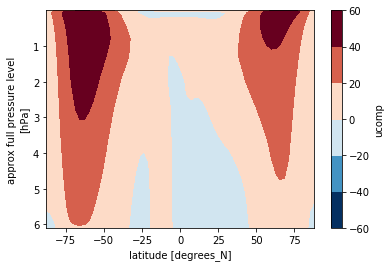

In [38]:
u_z.plot.contourf(yincrease=False)

We set `yincrease=False` to have the highest pressure at the bottom (as in the real atmosphere). Often we want to plot a logarithmic vertical scale (since $p=p_0e^{-z/H}$). For this we'll need to use a more advanced plotting method, which I'll cover in a later guide.

Now let's plot zonal-mean zonal wind at a given pressure level (say 1 hPa), as a function of time and latitude.

In [39]:
u_1hPa = d.ucomp.sel(pfull=1, method='nearest').mean(dim='lon')
print(u_1hPa)

<xarray.DataArray 'ucomp' (time: 30, lat: 64)>
array([[ 4.867181 , 11.427292 , 18.391155 , ..., 13.08112  ,  8.4246235,
         3.6550272],
       [ 4.5038586, 10.582941 , 17.105206 , ..., 13.60862  ,  9.222387 ,
         4.202294 ],
       [ 4.893614 , 11.563828 , 18.49185  , ..., 15.607358 , 10.606018 ,
         4.846463 ],
       ...,
       [ 4.949478 , 12.278374 , 19.788116 , ..., 16.4813   , 11.143576 ,
         5.043433 ],
       [ 4.3500547, 11.676207 , 19.795734 , ..., 20.068367 , 12.415895 ,
         5.137204 ],
       [ 3.798656 , 10.531549 , 17.905903 , ..., 25.753407 , 17.171795 ,
         7.620375 ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * time     (time) float64 706.8 707.8 708.9 709.9 ... 733.4 734.4 735.5 736.5
    pfull    float64 0.7886


We have used the `sel` method to get a particular pressure level. The `method = 'nearest'` part says that if there isn't a pressure level at exactly 1 hPa then use the closest (it has chosen 0.7886 hPa as you can see above). Now let's plot the output:

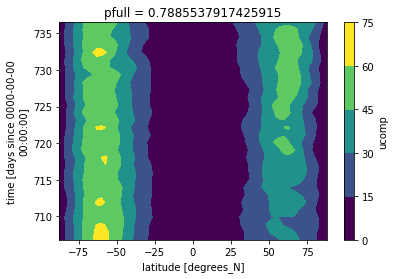

In [40]:
u_1hPa.plot.contourf()

The time unit here is just days since the simulation began. This isn't particularly informative for Mars so later on we'll get to using a different unit called solar longitude.

# Reading multiple files at once



Isca partitions output into separate files (typically one for each month of the simulation), so we have files that look like:
- `run0001/atmos_daily.nc`
- `run0002/atmos_daily.nc` 
etc.

It would be nice to read these all in together so we can analyse time series over the whole simulation. However, this could be a lot of data (more than the memory of the machine). Luckily a package called Dask handles all this cleverly in the background for us.  

In [41]:
import dask

Now we will read in all the data from the simulation using `xr.open_mfdataset` (mf stands for multi-file):

In [42]:
da = xr.open_mfdataset('/export/anthropocene/array-01/kz18101/Isca_data/soc_mars_mk36_per_value70.85_none_mld_2.0_with_mola_topo/run*/atmos_daily.nc', 
                       decode_times=False, concat_dim='time',combine='nested')
print(da)

<xarray.Dataset>
Dimensions:           (lat: 64, latb: 65, lon: 128, lonb: 129, nv: 2, pfull: 25, phalf: 26, scalar_axis: 1, time: 1080)
Coordinates:
  * phalf             (phalf) float64 0.0 0.0009334 0.002829 ... 6.081 6.093 6.1
  * lat               (lat) float64 -87.86 -85.1 -82.31 ... 82.31 85.1 87.86
  * scalar_axis       (scalar_axis) float64 0.0
  * pfull             (pfull) float64 0.0003434 0.001797 ... 6.087 6.096
  * latb              (latb) float64 -90.0 -86.58 -83.76 ... 83.76 86.58 90.0
  * lonb              (lonb) float64 -1.406 1.406 4.219 ... 353.0 355.8 358.6
  * nv                (nv) float64 1.0 2.0
  * lon               (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * time              (time) float64 0.5118 1.535 2.559 ... 1.104e+03 1.105e+03
Data variables:
    ps                (time, lat, lon) float32 dask.array<chunksize=(30, 64, 128), meta=np.ndarray>
    bk                (time, phalf) float32 dask.array<chunksize=(30, 26), meta=np.ndarray>
    

We now have 1080 time points (compared to 30 for the single file earlier). Let's plot the same latitude-time figure as before, but now with the extended time range:

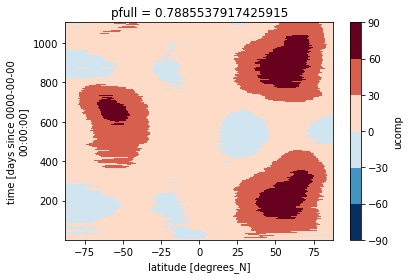

In [43]:
da.ucomp.sel(pfull=1, method='nearest').mean(dim='lon').plot.contourf()

We see a seasonal cycle of stronger Northern Hemisphere jets, and weaker Southern Hemisphere jets in their respective winters. 

# Taking a Mars seasonal average

**This part is only relevant for Mars-based simulations**

The default time coordinate is in days, which perhaps isn't the most appropriate for Mars, and is tricky to divide into Martian seasons. A useful coordinate is 'solar longitude', $L_S$ - this tells the time of year [in terms of an angle around the sun](http://www-mars.lmd.jussieu.fr/mars/time/solar_longitude.html). NH summer solstice is at 90$^{\circ}$ and NH winter solstice is at 270$^\circ$. Hence we can construct seasons as follows:

- 45 - 135: NH Summer
- 135 - 225: NH Autumn
- 225 - 315: NH Winter
- 315 - 45: NH Spring

The model outputs solar longiude as a variable:

<xarray.DataArray 'mars_solar_long' (time: 1080, scalar_axis: 1)>
dask.array<concatenate, shape=(1080, 1), dtype=float32, chunksize=(30, 1), chunktype=numpy.ndarray>
Coordinates:
  * scalar_axis  (scalar_axis) float64 0.0
  * time         (time) float64 0.5118 1.535 2.559 ... 1.104e+03 1.105e+03
Attributes:
    long_name:      Martian solar longitude
    units:          deg
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT


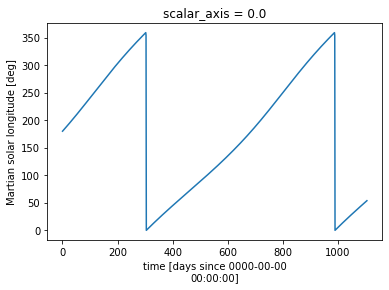

In [44]:
print(da.mars_solar_long)
da.mars_solar_long.plot()

You'll notice those lines aren't exactly straight (i.e. a day doesn't equal a set increment in solar longitude). This is because Mars's orbit is fairly elliptical. [Timekeeping on Mars](https://en.wikipedia.org/wiki/Timekeeping_on_Mars) is a bit tricky!

We can also see the simulation we have is a little under 2 Martian 

In order to average a variable over a range of solar longitudes, we need to use the `where` command to select the relevant range. Let's take an average over the NH winter season.

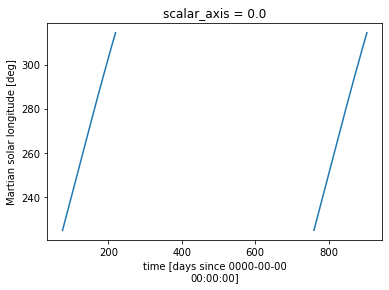

In [45]:
da_nh_winter = da.where((da.mars_solar_long < 315) & (da.mars_solar_long > 225))
da_nh_winter.mars_solar_long.plot()

We have two years' worth of NH winter data, but the rest has now been masked out (compare two plots of solar longitude). Now we can take a time and zonal mean of the zonal wind:

In [46]:
u_z_nh_winter = da_nh_winter.ucomp.mean(dim = ['time','lon'])
print(u_z_nh_winter)

<xarray.DataArray 'ucomp' (pfull: 25, lat: 64, scalar_axis: 1)>
dask.array<mean_agg-aggregate, shape=(25, 64, 1), dtype=float32, chunksize=(25, 64, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * scalar_axis  (scalar_axis) float64 0.0
  * pfull        (pfull) float64 0.0003434 0.001797 0.004659 ... 6.087 6.096


You'll see a dummy coordinate 'scalar_axis' has been added. I'm not quite sure why this is(!) but we need to remove it before plotting:

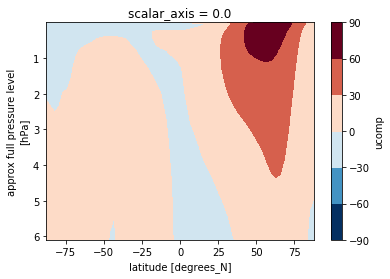

In [47]:
u_z_nh_winter.isel(scalar_axis=0).plot.contourf(yincrease=False)

Now we see a jet only in the NH, as expected for NH winter (compare with all times averaged plot above).

# Faceted plots with Xarray

Sometimes we want to produce an array of plots to show a variable at different levels, latitudes, etc. Xarray has a nice way of doing this ([more here under 'Faceting'](http://xarray.pydata.org/en/stable/plotting.html)). 

Returning to the non seasonally-averaged data array, let's produce a plot of time-mean zonal wind at each pressure level.

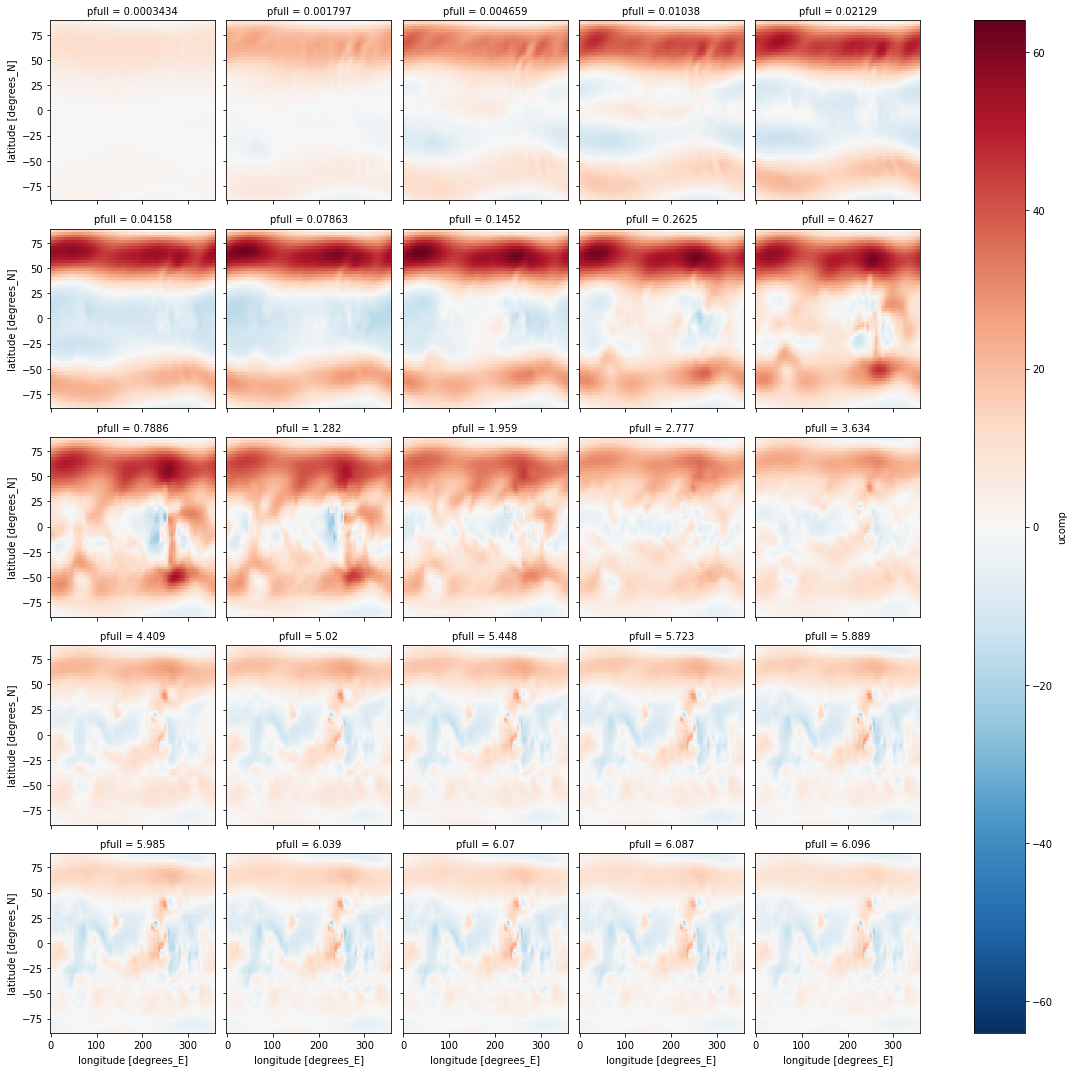

In [48]:
da.ucomp.mean(dim='time').plot.pcolormesh(col='pfull', col_wrap=5)

We can also plot every nth level, by using a `slice` command. Here is temperature at every 5th level.

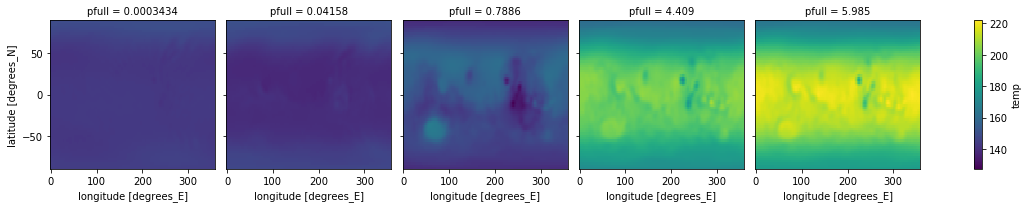

In [49]:
da.temp.mean(dim='time').isel(pfull=slice(0,None,5)).plot(col='pfull')

# Calculating a global mean

A tricky point when working with a lat-lon grid is that the area of individual grid cells varies over the globe. They decrease as $\cos(\mathrm{latitude})$ from equator to pole. Hence we need to weight a global average according to this, as follows:

Let's try to make a time series of global mean surface temperature (GMST):

First make an array of the weights:

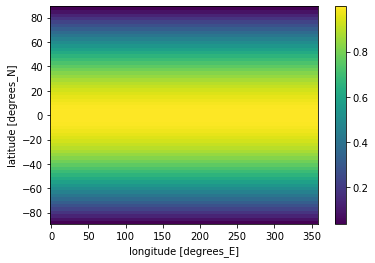

In [50]:
cos_lat_2d = np.cos(np.deg2rad(da.lat)) * xr.ones_like(da.lon) 
cos_lat_2d.plot()

We now sum the product of the surface temperature (variable `t_surf`) and weights, and divide by the sum of the weights:

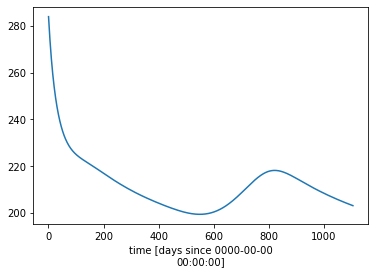

In [51]:
gmst = (da.t_surf * cos_lat_2d).sum(dim=['lat','lon']) / cos_lat_2d.sum(dim=['lat','lon'])
gmst.plot()

You can see the initial temperature was too high and the model cools, eventually reaching equilibrium (with a seasonal cycle) around 500 days. This initial period is known as 'spin-up'